## Imports

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, loggers
import torchvision.transforms as T
from pytorch_lightning.callbacks import ModelCheckpoint
import torchmetrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from torchsummary import summary

import matplotlib.pyplot as plt

from dataset import SpectrogramDataset
from utils import plot_confusion_matrix
import time

d:\OneDrive\Github\tallosim_audio_explorers\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define CNN model

In [2]:
class CNNClassifier(pl.LightningModule):
    def __init__(self, classes):
        super(CNNClassifier, self).__init__()
        
        self.classes = classes
        self.num_classes = len(classes)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(64 * 4 * 1, 128)
        self.fc2 = nn.Linear(128, self.num_classes)        
        #self.fc1 = nn.Linear(128 * 2 * 6, 256)
        #self.fc2 = nn.Linear(256, self.num_classes)
        
        self.relu = nn.ReLU()
        
        self.criterion = nn.CrossEntropyLoss()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=self.num_classes, task='multiclass')
        
        self.test_confusion_matrix = np.zeros((self.num_classes, self.num_classes))
    
    
        
    def forward(self, x):
        # print type and shape of input tensor
        #x = x.type(torch.FloatTensor)
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        #x = self.relu(self.conv4(x))
        #x = self.maxpool(x)
        #x = x.view(-1, 128 * 4 * 12)
        x = x.view(-1, 64 * 4 * 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('train_acc', accuracy, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('val_acc', accuracy)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        
        _, predicted = torch.max(y_hat, 1)
        accuracy = (predicted == y).sum().item() / len(y)
        self.log('test_acc', accuracy)
        
        confusion_matrix = self.confusion_matrix(predicted, y)
        self.test_confusion_matrix += confusion_matrix.cpu().numpy()
    
        
        
    def test_epoch_end(self, outputs):
        plot_confusion_matrix(self.test_confusion_matrix, self.classes, filename='confusion_matrix.png')
        
        """num_classes = self.num_classes
        # plot the precision-recall curves for all classes
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
        for i, color in zip(range(num_classes), colors):
            ax.plot(self.recall_vals[i], self.precision_vals[i], label=f"Class {self.classes[i]}", color=color)


        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title("Precision-Recall Curve for all Classes")
        ax.legend()
        plt.show()"""
                
    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        if len(batch) == 2:
            x, y = batch
            
            y_hat = self(x)
            _, predicted = torch.max(y_hat, 1)
            return y_hat, y
        else:
            x = batch
            y_hat = self(x)
            
            _, predicted = torch.max(y_hat, 1)
            return y_hat

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

## Load data and labels

In [3]:
spectrograms = np.load('data/training.npy')
labels = np.load('data/training_labels.npy')

print('Spectrogram shape:', spectrograms.shape)
print('Labels shape:', labels.shape)

print('Spectrogram dtype:', spectrograms.dtype)

Spectrogram shape: (52890, 32, 96)
Labels shape: (52890,)
Spectrogram dtype: float32


## Split data

In [4]:
TRAINING_RATIO = 0.8
VALIDATION_RATIO = 0.1
TEST_RATIO = 0.1

if TRAINING_RATIO + VALIDATION_RATIO + TEST_RATIO != 1:
    raise ValueError('Training, validation, and test ratios must sum to 1.')

train_size = int(TRAINING_RATIO * len(spectrograms))
val_size = int(VALIDATION_RATIO * len(spectrograms))
test_size = len(spectrograms) - train_size - val_size

train_spectrograms, val_spectrograms, train_labels, val_labels = train_test_split(spectrograms, labels, test_size=val_size, random_state=42)
train_spectrograms, test_spectrograms, train_labels, test_labels = train_test_split(train_spectrograms, train_labels, test_size=test_size, random_state=42)

print('Training samples:', train_spectrograms.shape[0])
print('Validation samples:', val_spectrograms.shape[0])
print('Test samples:', test_spectrograms.shape[0])

    

Training samples: 42312
Validation samples: 5289
Test samples: 5289


## Split spectrograms up in 8 time frames

Each spectrogram is a 2 second snippet of sound in the shape of 32x96.
We can seperate the spectrograms into 8 time frames.
Therefore, from a single 2 second spectrogram we will get 8 spectrograms of 0.25 seconds each.
This will give us a resolution of 32x12 for each spectrogram.

In [5]:
def split_data(old_spectrograms, old_labels):
    counter = 0
    new_spectrograms = np.zeros((old_spectrograms.shape[0] * 8, 32, 12), dtype=np.float32)
    new_labels = np.zeros((old_labels.shape[0]*8))
    for i in range(old_spectrograms.shape[0]):
        for j in range(0,old_spectrograms.shape[2], 12):
            counter += 1
            new_value = old_spectrograms[i, :, j:j+12]
            new_spectrograms[i * 8 + j//12] = np.float32(new_value)
            new_labels[i * 8 + j//12] = old_labels[i]
    print(counter)
    return new_spectrograms, new_labels

new_train_spectrograms, new_train_labels = split_data(train_spectrograms, train_labels)
new_val_spectrograms, new_val_labels = split_data(val_spectrograms, val_labels)
new_test_spectrograms, new_test_labels = split_data(test_spectrograms, test_labels)
print('Training samples:', new_train_spectrograms.shape[0])
print('Validation samples:', new_val_spectrograms.shape[0])
print('Test samples:', new_test_spectrograms.shape[0])
        

338496
42312
42312
Training samples: 338496
Validation samples: 42312
Test samples: 42312


## Augmentation of data

In [6]:
# Define data transforms for data augmentation
transform1 = transforms.Compose([
    # Tranform to tensor with type as float32 
    transforms.ToTensor(),
    # Add more transforms here
])


## Create datasets and dataloaders

In [7]:
BATCH_SIZE = 64
NUM_WORKERS = 4

# Create datasets and dataloaders
train_dataset = SpectrogramDataset(new_train_spectrograms, new_train_labels, transform=transform1)

val_dataset = SpectrogramDataset(new_val_spectrograms, new_val_labels, transform=transforms.ToTensor())
test_dataset = SpectrogramDataset(new_test_spectrograms, new_test_labels, transform=transforms.ToTensor())

#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
#test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Load model

In [8]:
CLASSES = ['Other', 'Music', 'Human voice', 'Engine sounds', 'Alarm']

model = CNNClassifier(classes=CLASSES)

summary(model, (1, 32, 12), device='cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 12]             160
              ReLU-2           [-1, 16, 32, 12]               0
         MaxPool2d-3            [-1, 16, 16, 6]               0
            Conv2d-4            [-1, 32, 16, 6]           4,640
              ReLU-5            [-1, 32, 16, 6]               0
         MaxPool2d-6             [-1, 32, 8, 3]               0
            Conv2d-7             [-1, 64, 8, 3]          18,496
              ReLU-8             [-1, 64, 8, 3]               0
         MaxPool2d-9             [-1, 64, 4, 1]               0
           Linear-10                  [-1, 128]          32,896
             ReLU-11                  [-1, 128]               0
           Linear-12                    [-1, 5]             645
Total params: 56,837
Trainable params: 56,837
Non-trainable params: 0
---------------------------------

## Prepare for training

In [9]:
MAX_EPOCHS = 100
VERSION = 'cnn_v2_epoch-30-v21'

accelerator = None
if torch.cuda.is_available():
    accelerator = 'gpu'
elif torch.backends.mps.is_available():
    accelerator = 'cpu'  # MPS is not implemented in PyTorch yet

tb_logger = loggers.TensorBoardLogger('.', version=VERSION)
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max', save_top_k=1, save_last=True, filename='best-{epoch}-{val_acc:.2f}')

trainer = Trainer(accelerator=accelerator, max_epochs=MAX_EPOCHS, logger=tb_logger, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Start training

In [10]:
#trainer.fit(model, train_loader, val_loader)

## Analyzing results

In [11]:
# Load previously trained model
CHECKPOINT_PATH = f'lightning_logs/{VERSION}/checkpoints/best-epoch=21-val_acc=0.84.ckpt'

model = CNNClassifier.load_from_checkpoint(CHECKPOINT_PATH, classes=CLASSES)
print(f'Model size: {os.path.getsize(CHECKPOINT_PATH) / 1e6} MB')

model.eval()
x = torch.randn(1, 32, 12)

with torch.no_grad():
    t1 = time.time()
    y_hat = model(x)
    print(f'Inference time: {time.time() - t1:.6f} seconds')

Model size: 0.696426 MB
Inference time: 0.001000 seconds


### Plot Confusion Matrix

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 662/662 [00:04<00:00, 165.44it/s]

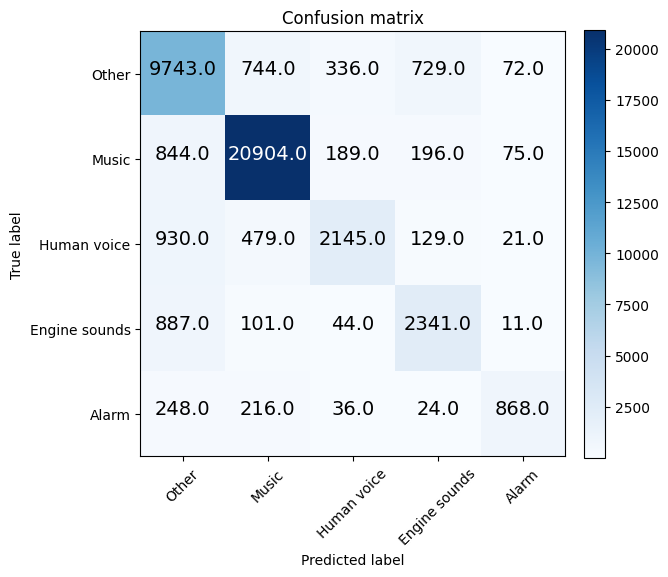

Testing DataLoader 0: 100%|██████████| 662/662 [00:04<00:00, 156.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8508461117744446
        test_loss           0.43726083636283875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [12]:
results = trainer.test(model, test_loader) # This not the challenge, test set

### Plot Precision Recall curve for each time frame

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 662/662 [00:01<00:00, 383.53it/s]


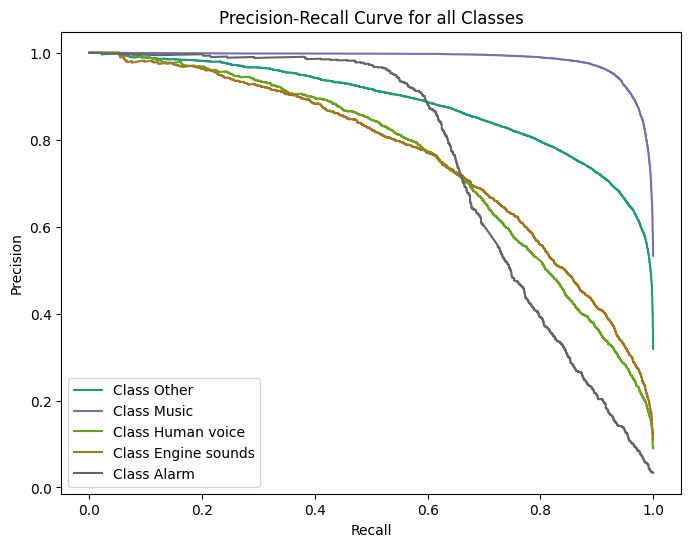

In [13]:
predictions = trainer.predict(model, test_loader) # This is the challenge, test set

preds = torch.cat([t[0] for t in predictions], dim=0)
target = torch.cat([t[1] for t in predictions], dim=0)

mcprc = torchmetrics.classification.MulticlassPrecisionRecallCurve(num_classes=len(CLASSES), average='macro')
precision, recall, thresholds = mcprc(preds, target)

# plot the precision-recall curves for all classes
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Dark2(np.linspace(0, 1, len(CLASSES)))
for i, color in zip(range(len(CLASSES)), colors):
    ax.plot(recall[i], precision[i], label=f"Class {CLASSES[i]}", color=color)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve for all Classes")
ax.legend()
plt.show()

### Plot Precision Recall curve for the combined 8 time frames

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 662/662 [00:01<00:00, 433.52it/s]
torch.Size([5289, 5])
torch.Size([5289])


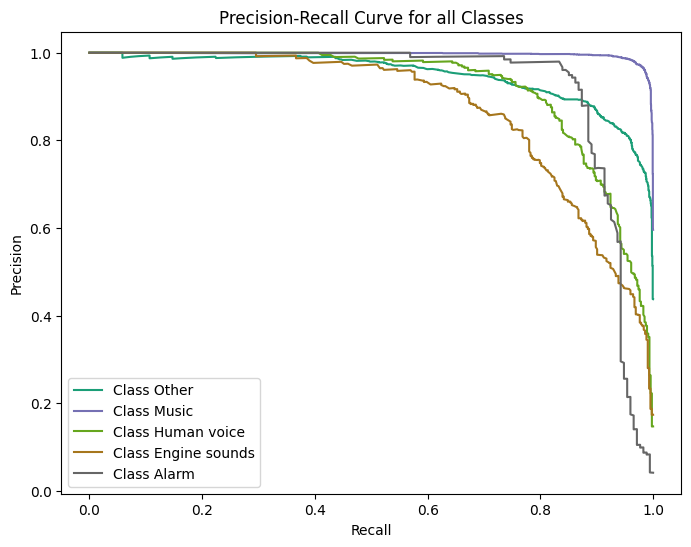

In [14]:
# Make predictions
predictions = trainer.predict(model, test_loader) # This is the challenge, test set

# Get the predictions and targets
preds = torch.cat([t[0] for t in predictions], dim=0)
target = torch.cat([t[1] for t in predictions], dim=0)

# No we need to combine the 8 0.25 second predictions into one 2 second prediction
# We will do this through a for loop, that for each loop takes the 8 predictions and averages them into one prediction for each class
# Target is the same for each of the 8 predictions, so we can just take the first one and append it one time
denominator = 8

new_preds = torch.zeros((preds.shape[0]//denominator, preds.shape[1]))
new_target = torch.zeros((target.shape[0]//denominator))
print(new_preds.shape)
print(new_target.shape)
for i in range(preds.shape[0]//denominator):
    tmp_preds = preds[i*denominator:(i*denominator)+denominator] # Save the 8 predictions in a temporary buffer.
    for j in range(len(tmp_preds)):
        new_preds[i] += tmp_preds[j]
    new_preds[i] = new_preds[i] // denominator
    # Convert the target to long tensor, because it is a float tensor for some reason
    new_target[i] = target[i*denominator].type(torch.LongTensor)

new_target = new_target.type(torch.LongTensor)
mcprc = torchmetrics.classification.MulticlassPrecisionRecallCurve(num_classes=len(CLASSES), average='macro')
precision, recall, thresholds = mcprc(new_preds, new_target)

# plot the precision-recall curves for all classes
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.Dark2(np.linspace(0, 1, len(CLASSES)))
for i, color in zip(range(len(CLASSES)), colors):
    ax.plot(recall[i], precision[i], label=f"Class {CLASSES[i]}", color=color)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve for all Classes")
ax.legend()
plt.show()

### Plot Confusion matrix for the combined 8 time frames

test_loss tensor(0.2373)
5289
5289
test_acc 0.9092456040839478


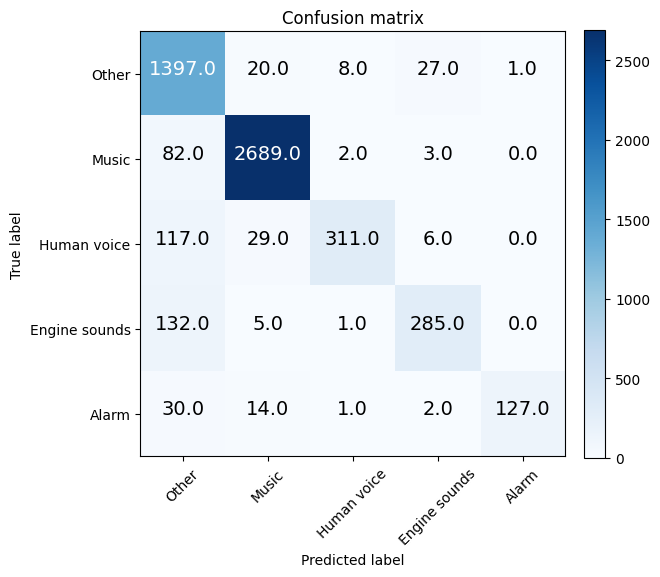

[]

In [15]:
num_classes = len(CLASSES)
# Define our confusion_matrix class
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='multiclass')
# Define our confusion matrix
test_confusion_matrix = np.zeros((num_classes, num_classes))

# Take our predictions from before and apply to confusion matrix
criterion = nn.CrossEntropyLoss()
loss = criterion(new_preds, new_target)
print('test_loss', loss)

_, predicted = torch.max(new_preds, 1)
print(len(predicted))
print(len(new_target))
accuracy = (predicted == new_target).sum().item() / len(new_target)
print('test_acc', accuracy)

confusion_matrix = confusion_matrix(predicted, new_target)
test_confusion_matrix += confusion_matrix.cpu().numpy()

plot_confusion_matrix(test_confusion_matrix, CLASSES, filename='confusion_matrix.png')

[]

## Perform predictions on unknown test set

In [16]:
def split_data(old_spectrograms):
    counter = 0
    new_spectrograms = np.zeros((old_spectrograms.shape[0] * 8, 32, 12), dtype=np.float32)
    for i in range(old_spectrograms.shape[0]):
        for j in range(0,old_spectrograms.shape[2], 12):
            counter += 1
            new_value = old_spectrograms[i, :, j:j+12]
            new_spectrograms[i * 8 + j//12] = np.float32(new_value)
    print(counter)
    return new_spectrograms

In [17]:
spectrograms_to_predict = np.load('data/test.npy')

print('Test spectrogram to predict shape:', spectrograms_to_predict.shape)
print('Test spectrogram to predict dtype:', spectrograms_to_predict.dtype)

spectrograms_to_predict = split_data(spectrograms_to_predict)

print('Test spectrogram to predict shape:', spectrograms_to_predict.shape)
print('Test spectrogram to predict dtype:', spectrograms_to_predict.dtype)

Test spectrogram to predict shape: (5347, 32, 96)
Test spectrogram to predict dtype: float32
42776
Test spectrogram to predict shape: (42776, 32, 12)
Test spectrogram to predict dtype: float32


In [18]:
test_to_predict_dataset = SpectrogramDataset(spectrograms_to_predict, transform=transforms.ToTensor())
test_to_predict_loader = DataLoader(test_to_predict_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


In [19]:
predictions = trainer.predict(model, test_to_predict_loader)
preds = torch.cat([t for t in predictions], dim=0)
print(preds.shape)

You are using a CUDA device ('NVIDIA GeForce RTX 3070 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 669/669 [00:01<00:00, 382.41it/s]
torch.Size([42776, 5])


In [20]:
denominator = 8
new_preds = torch.zeros((preds.shape[0]//denominator, preds.shape[1]))
for i in range(preds.shape[0]//denominator):
    tmp_preds = preds[i*denominator:(i*denominator)+denominator] # Save the 8 predictions in a temporary buffer.
    for j in range(len(tmp_preds)):
        new_preds[i] += tmp_preds[j]
    new_preds[i] = new_preds[i] // denominator

print(new_preds.shape)
_, predicted = torch.max(new_preds, 1)
print(len(predicted))
#predictions = np.concatenate(predicted).astype(int)

torch.Size([5347, 5])
5347


In [22]:
np.savetxt('predictions.txt', predicted, delimiter='\n', fmt='%d')

## Load predictions and count class distribution

In [23]:
# load the predictions

with open('predictions.txt') as f:
    predictions = f.readlines()
    
# convert to int
predictions = [int(x.strip()) for x in predictions]

# Find the class distribution
class_distribution = np.zeros(len(CLASSES))
for i in range(len(CLASSES)):
    class_distribution[i] = predictions.count(i)
print(class_distribution)


[2794. 2014.  264.  237.   38.]
